# Large Movie Review Dataset

Binary Sentiment classification of a large movie review dataset using Tensorflow hub.
Dataset contains a set of 25,000 highly polar movie reviews for training, and 25,000 for testing.

# Install required libraries

In [17]:
!pip install tensorflow-hub

# Import Libraries/Dataset 

### Import the required libraries and the dataset
### Load the texts and add labels as ‘pos’ and ‘neg’

In [18]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from tensorflow.keras import regularizers
from keras.layers import Dropout
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [19]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df

In [20]:
train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,"From the mind of Robert Bloch, of ""Psycho"" fam...",7,1
1,'The Mother' is that extraordinary piece of fi...,9,1
2,*Spoilers and extreme bashing lay ahead*<br />...,1,0
3,Nowhere near the original. It's quite accurate...,4,0
4,"""Trigger Man"" is definitely the most boring an...",1,0


# Data Visualization

### Print at least two texts from each class of the dataset(pos and neg), for a sanity check that labels match the text.
### Plot a bar graph of class distribution in a dataset. Each bar depicts the number of texts belonging to a particular sentiment.

In [21]:
p=0
for i in range(25):
  if(train_df.loc[i,'polarity']==1):
    print('Positive')
    print(train_df.loc[i,'sentence'])
    p=p+1
  if(p==2):
    break

Positive
From the mind of Robert Bloch, of "Psycho" fame, come four tales of twisty terror in this Amicus anthology film, which, while not quite as much fun, or scary, as I would have liked, still provides for some decent genre entertainment.<br /><br />It's linked by the wrap-around story of a highly skeptical Scotland Yard detective (John Bennett) who is investigating the disappearance of a prominent actor; he's advised that this case is linked to a few others by the house in which they all took place, and our film is off and running.<br /><br />"Method for Murder" has author Charles Hillyer (always delightful Denholm Elliott) haunted by his latest fictional creation, who has seemingly come to life. This sequence has some good surreal and fairly suspenseful moments, and is capped by a reasonably amusing revelation and denouement.<br /><br />"Waxworks" stars horror icon Peter Cushing as retired stockbroker Philip Grayson, who, along with old friend Neville Rogers (Joss Ackland) become

In [22]:
p=0
for i in range(25):
  if(train_df.loc[i,'polarity']==0):
    print('Negative')
    print(train_df.loc[i,'sentence'])
    p=p+1
  if(p==2):
    break

Negative
*Spoilers and extreme bashing lay ahead*<br /><br />When this show first started, I found it tolerable and fun. Fairly Oddparents was the kind of cartoon that kids and adults liked. It also had high ratings along with Spongebob. But it started to fall because of the following crap that Butch Hartman and his team shoved into the show.<br /><br />First off, toilet humor isn't all that funny. You can easily pull off a fast laugh from a little kiddie with a burp, but that's pretty much the only audience that would laugh at such a cliché joke. Next there are the kiddie jokes. Lol we can see people in their underwear and we can see people cross-dressing. LOLOLOL!!! I just can't stop laughing at such gay bliss! Somebody help me! But of course, this show wouldn't suck that bad if it weren't for stereotypes. Did you see how the team portrayed Australians? They saw them as nothing but kangaroo-loving, boomerang-throwing simpletons who live in a hot desert. But now... Is the coup de grac

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


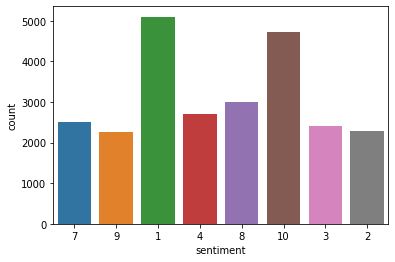

In [23]:
sns.countplot(train_df["sentiment"])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


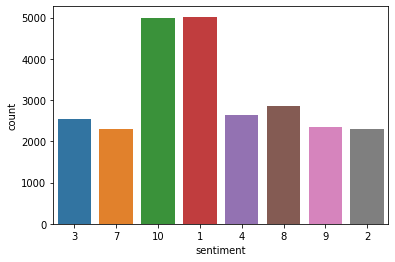

In [24]:
sns.countplot(test_df["sentiment"])
plt.show()

### Print the shapes of train and test data

In [25]:
train_df['sentence'].shape

(25000,)

In [26]:
test_df['sentence'].shape

(25000,)

# Data Pre-processing

### Use the pre-trained embedding layer from TensorFlow hub for this.
### Bring the train and test data in the required format.

In [27]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_df['sentence'])

<tf.Tensor: shape=(25000, 128), dtype=float32, numpy=
array([[ 1.6380529 , -0.24274953,  0.14494555, ..., -0.17876726,
         0.06122979,  0.12872425],
       [ 0.8657096 , -0.03169522,  0.20286714, ..., -0.23955654,
        -0.02084394,  0.0542068 ],
       [ 1.5291444 , -0.05903781,  0.11815045, ..., -0.5511628 ,
        -0.12316099, -0.12828201],
       ...,
       [ 1.7303226 , -0.11275347,  0.40194368, ..., -0.23818775,
        -0.04214795, -0.06588016],
       [ 1.1244911 , -0.02608649,  0.17636   , ..., -0.22172062,
        -0.13328645,  0.08112609],
       [ 1.1851424 ,  0.03584916,  0.32103047, ..., -0.21483175,
         0.01558539,  0.1524307 ]], dtype=float32)>

# Model Building 
### Sequential Model layers- Use AT LEAST 3 hidden layers with appropriate input for each. Choose the best number for hidden units and give reasons.
###Add L2 regularization to all the layers.
###Add one layer of dropout at the appropriate position and give reasons.
###Choose the appropriate activation function for all the layers.
###Print the model summary.

Let's now build the full model:

In [28]:
def initialise():
  model = tf.keras.Sequential()
  model.add(hub_layer)
  model.add(tf.keras.layers.Dense(128, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
  model.add(tf.keras.layers.Dropout(.2))
  model.add(tf.keras.layers.Dense(70, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
  model.add(tf.keras.layers.Dense(50, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
  model.add(tf.keras.layers.Dense(20, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
  model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
  return model

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs logits (a single-unit layer with a linear activation), you'll use the `binary_crossentropy` loss function.

This isn't the only choice for a loss function, you could, for instance, choose `mean_squared_error`. But, generally, `binary_crossentropy` is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when you are exploring regression problems (say, to predict the price of a house), you'll see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [29]:
for i in [1,0.1,0.01,0.001,0.0001,0.00001]:
  model = initialise()
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=i),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
  print("Learning rate = ",i)
  model_fit = model.fit(train_df['sentence'], train_df['polarity'], validation_data = (test_df['sentence'], test_df['polarity']), epochs = 1, batch_size=512)

Learning rate =  1


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


49/49 [==============================] - 6s 117ms/step - loss: 234001.6719 - accuracy: 0.5036 - val_loss: 7154.9160 - val_accuracy: 0.5000
Learning rate =  0.1
49/49 [==============================] - 6s 115ms/step - loss: 169.5032 - accuracy: 0.5007 - val_loss: 27.0705 - val_accuracy: 0.5000
Learning rate =  0.01
49/49 [==============================] - 6s 110ms/step - loss: 5.4630 - accuracy: 0.5694 - val_loss: 2.2589 - val_accuracy: 0.7090
Learning rate =  0.001
49/49 [==============================] - 6s 112ms/step - loss: 3.8981 - accuracy: 0.5890 - val_loss: 2.7764 - val_accuracy: 0.7032
Learning rate =  0.0001
49/49 [==============================] - 6s 113ms/step - loss: 4.9259 - accuracy: 0.5388 - val_loss: 3.5783 - val_accuracy: 0.6382
Learning rate =  1e-05
49/49 [==============================] - 6s 111ms/step - loss: 16.7054 - accuracy: 0.5001 - val_loss: 11.2108 - val_accuracy: 0.5000


Chosing learning rate = 0.001 based on accuracy

In [30]:
#initialise the model
model = initialise()

# summary of model
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_65 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 70)                9030      
_________________________________________________________________
dense_67 (Dense)             (None, 50)                3550      
_________________________________________________________________
dense_68 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_69 (Dense)             (None, 1)               

#Model Compilation

### Compile the model with the appropriate loss function.
### Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.
### Use accuracy as a metric.

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model Training 

### Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.
### Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

## Train the model

Train the model for 10 epochs in mini-batches of 512 samples. This is 10 iterations over all samples in the `x_train` and `y_train` tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [32]:
from time import time
#fitting model
start=time()
model_fit = model.fit(train_df['sentence'], train_df['polarity'], validation_data = (test_df['sentence'], test_df['polarity']), epochs = 50, batch_size=512)
totaltime = time() - start

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


49/49 [==============================] - 6s 110ms/step - loss: 4.2089 - accuracy: 0.5685 - val_loss: 2.8124 - val_accuracy: 0.7057
Epoch 2/50
49/49 [==============================] - 5s 106ms/step - loss: 2.6508 - accuracy: 0.6738 - val_loss: 2.3470 - val_accuracy: 0.7443
Epoch 3/50
49/49 [==============================] - 5s 107ms/step - loss: 2.2368 - accuracy: 0.7268 - val_loss: 2.0680 - val_accuracy: 0.7856
Epoch 4/50
49/49 [==============================] - 5s 108ms/step - loss: 1.9844 - accuracy: 0.7804 - val_loss: 1.8813 - val_accuracy: 0.7985
Epoch 5/50
49/49 [==============================] - 5s 108ms/step - loss: 1.8171 - accuracy: 0.8019 - val_loss: 1.7608 - val_accuracy: 0.8031
Epoch 6/50
49/49 [==============================] - 5s 108ms/step - loss: 1.7023 - accuracy: 0.8152 - val_loss: 1.6988 - val_accuracy: 0.7897
Epoch 7/50
49/49 [==============================] - 5s 107ms/step - loss: 1.6115 - accuracy: 0.8216 - val_loss: 1.5703 - val_accuracy: 0.8192
Epoch 8/50
49/49 

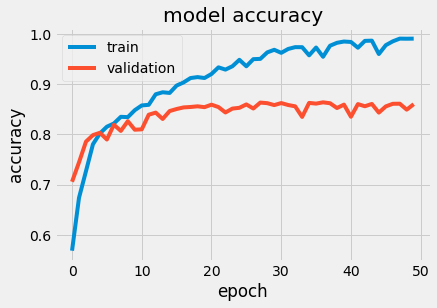

In [33]:
plt.style.use('fivethirtyeight')
#  "Accuracy"
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

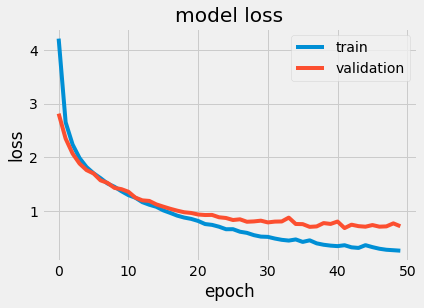

In [34]:
# "Loss"
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

# Model Evaluation

### Print the final train and validation loss and accuracy. Print confusion matrix and classification report for the validation dataset. Analyze and report the best and worst performing class.
### Print the two most incorrectly classified texts for each class in the test dataset.

## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [35]:
print("Time taken for training", totaltime,"seconds")

Time taken for training 322.52769947052 seconds


In [36]:
# evaluating model
model.evaluate(test_df['sentence'], test_df['polarity'])

782/782 [==============================] - 4s 5ms/step - loss: 0.7154 - accuracy: 0.8601


[0.7153971791267395, 0.8600800037384033]

This fairly naive approach achieves an accuracy of about 87%. With more advanced approaches, the model should get closer to 95%.

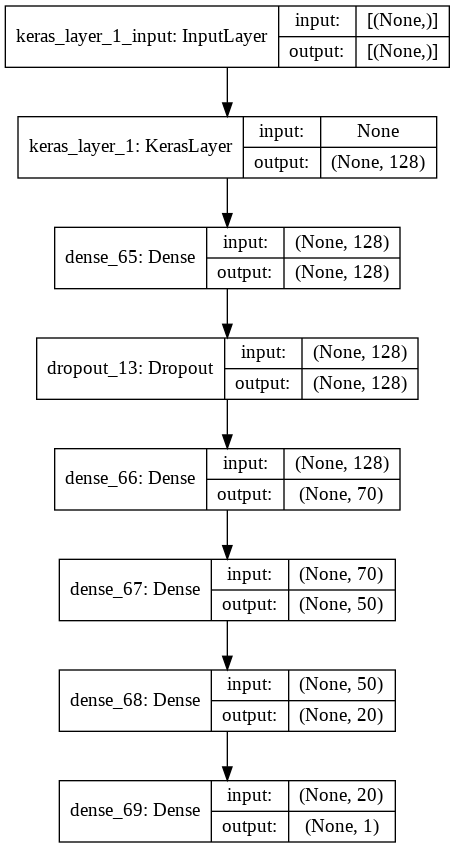

In [37]:
plot_model(model, show_shapes = True)

In [38]:
# making predictions

y_probs = model.predict(test_df['sentence'])
y_preds = model.predict_classes(test_df['sentence'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [39]:
class_names = ["Neg", "Pos"]

In [40]:
print("Classification Report: \n", classification_report(test_df['polarity'], y_preds,target_names= class_names))

Classification Report: 
               precision    recall  f1-score   support

         Neg       0.86      0.86      0.86     12500
         Pos       0.86      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



Comparable performance of classes

In [41]:
print("Confusion Matrix: \n", confusion_matrix(test_df['polarity'], y_preds))

Confusion Matrix: 
 [[10710  1790]
 [ 1708 10792]]


In [42]:
print("Accuracy: \n", accuracy_score(test_df['polarity'], y_preds))

Accuracy: 
 0.86008


In [43]:
incorrect_df = test_df.copy()

In [44]:
incorrect_df['pred'] = y_preds

In [45]:
incorrect_df['prob'] = y_probs

In [46]:
incorrect_df = incorrect_df.sort_values(by='prob',ascending=False)

In [47]:
incorrect_df = incorrect_df.reset_index()
incorrect_df

,index,sentence,sentiment,polarity,pred,prob
0,12189,Trilogies are very interesting. Some go out wi...,10,1,1,1.000000e+00
1,16833,My mother is as Gone With The Wind as one can ...,10,1,1,1.000000e+00
2,22778,Director Mikhail Kalatozov's film The Cranes a...,9,1,1,1.000000e+00
3,1581,"Tony Hawk's Pro Skater 2x, isn't much differen...",9,1,1,1.000000e+00
4,14143,"Films belonging to the ""film noir"" genre usual...",9,1,1,1.000000e+00
...,...,...,...,...,...,...
24995,1321,"Snake Island is one of those films that, whils...",2,0,0,6.547768e-10
24996,7874,"Plankton, or Creatures from the Abyss as I'm p...",1,0,0,3.500739e-10
24997,8187,I think the cards were stacked against Webmast...,2,0,0,2.509929e-10
24998,24907,Interferencia starts as unemployed Martin Sand...,1,0,0,2.198497e-10


In [48]:
p=0
for i in range(25000):
  if(incorrect_df.loc[i,'polarity']==1):
    if(incorrect_df.loc[i,'pred']==0):
      print('Positive')
      print('Prediction Probability',round(incorrect_df.loc[i,'prob'],2),"%")
      print(incorrect_df.loc[i,'sentence'])
      p=p+1
  if(p==2):
    break

Positive
Prediction Probability 0.5 %
Here is a movie that almost gets it all right, with good performances from everyone, and three strong leading performances from Hanks, Seymour Hoffman, and a fine turn up from Julia Roberts that had me spell bound from the first few seconds, these are performances that lift the production to the stars, and keep it there for the duration. <br /><br />Apart from one or two very minor factual problems with the script, the only thing that lets this movie down, is the technical direction, there are far too many bad cuts (fudged continuity)and a number of camera "cheats" that simply do not work. This is surprising for a movie of this stature, and is a little annoying to watch, but it does not destroy an otherwise beautifully crafted film.
Positive
Prediction Probability 0.5 %
Crossing the Bridge: the Sound of Istanbul received one of the most rapturous applause from the audience when it ended and very deservingly so. I did not expect too much from a musi

In [49]:
p=0
for i in range(25000):
  if(incorrect_df.loc[i,'polarity']==0):
    if(incorrect_df.loc[i,'pred']==1):
      print('Negative')
      print('Prediction Probability',round(incorrect_df.loc[i,'prob'],2),"%")
      print(incorrect_df.loc[i,'sentence'])
      p=p+1
  if(p==2):
    break

Negative
Prediction Probability 1.0 %
Julie Delpy stars in this horrific film about a sadistic relationship between a father and a daughter in France of the 14th Century. The film attempts to shatter the romantic chivalry image of the heroic medieval knight, by showing a rather dreary image of the period, defined by psychological dysfunction, and violence. <br /><br />The movie opens with a child, François, growing up in the shadow of the Hundred Years' War, told by his father to keep his mother safe and to wait for his return. François takes action when he discovers his mother with a lover in bed. François murders him in the name of defending his father's honour. Like father like son, François grows up, and leaves his family, also to go to the same war. This setting is somewhat of an explanation for the events to come, as on his way home, we already notice that something is wrong with François. The war has not done well with him, he has changed.<br /><br />The daughter, Béatrice de Co

# Hyperparameter Tuning

### Build two more models by changing the following hyperparameters one at a time. Write the code for Model Building, Model Compilation, Model Training and Model Evaluation as given in the instructions above for each additional model

* Dropout: Change the position and value of dropout layer
* Batch Size: Change the value of batch size in model training

Write a comparison between each model and give reasons for the difference in results.

In [50]:
#hyperparamter tuning - changing dropout value
model_drop = tf.keras.Sequential()
model_drop.add(hub_layer)
model_drop.add(tf.keras.layers.Dense(128, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
model_drop.add(tf.keras.layers.Dense(70, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
model_drop.add(tf.keras.layers.Dropout(.5))
model_drop.add(tf.keras.layers.Dense(50, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
model_drop.add(tf.keras.layers.Dense(20, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
model_drop.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [51]:
model_drop.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
model_fit_drop = model_drop.fit(train_df['sentence'], train_df['polarity'], validation_data = (test_df['sentence'], test_df['polarity']), epochs = 50, batch_size=512)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


49/49 [==============================] - 6s 111ms/step - loss: 4.0639 - accuracy: 0.5783 - val_loss: 2.7818 - val_accuracy: 0.7388
Epoch 2/50
49/49 [==============================] - 5s 106ms/step - loss: 2.5483 - accuracy: 0.7161 - val_loss: 2.2802 - val_accuracy: 0.7904
Epoch 3/50
49/49 [==============================] - 5s 106ms/step - loss: 2.1089 - accuracy: 0.8026 - val_loss: 1.9550 - val_accuracy: 0.8366
Epoch 4/50
49/49 [==============================] - 5s 106ms/step - loss: 1.8178 - accuracy: 0.8710 - val_loss: 1.7912 - val_accuracy: 0.8422
Epoch 5/50
49/49 [==============================] - 5s 108ms/step - loss: 1.6217 - accuracy: 0.9053 - val_loss: 1.6853 - val_accuracy: 0.8496
Epoch 6/50
49/49 [==============================] - 5s 107ms/step - loss: 1.4677 - accuracy: 0.9366 - val_loss: 1.6206 - val_accuracy: 0.8568
Epoch 7/50
49/49 [==============================] - 5s 108ms/step - loss: 1.3625 - accuracy: 0.9498 - val_loss: 1.5510 - val_accuracy: 0.8621
Epoch 8/50
49/49 

In [53]:
model_fit_batch = model.fit(train_df['sentence'], train_df['polarity'], validation_data = (test_df['sentence'], test_df['polarity']), epochs = 50, batch_size=256)

Epoch 1/50
98/98 [==============================] - 9s 91ms/step - loss: 0.2331 - accuracy: 0.9961 - val_loss: 0.7797 - val_accuracy: 0.8570
Epoch 2/50
98/98 [==============================] - 9s 91ms/step - loss: 0.2172 - accuracy: 0.9968 - val_loss: 0.7782 - val_accuracy: 0.8541
Epoch 3/50
98/98 [==============================] - 9s 90ms/step - loss: 0.2791 - accuracy: 0.9692 - val_loss: 0.6694 - val_accuracy: 0.8599
Epoch 4/50
98/98 [==============================] - 9s 90ms/step - loss: 0.2040 - accuracy: 0.9966 - val_loss: 0.7375 - val_accuracy: 0.8588
Epoch 5/50
98/98 [==============================] - 9s 90ms/step - loss: 0.1910 - accuracy: 0.9970 - val_loss: 0.7495 - val_accuracy: 0.8571
Epoch 6/50
98/98 [==============================] - 9s 90ms/step - loss: 0.1792 - accuracy: 0.9977 - val_loss: 0.7297 - val_accuracy: 0.8578
Epoch 7/50
98/98 [==============================] - 9s 90ms/step - loss: 0.1709 - accuracy: 0.9976 - val_loss: 0.7328 - val_accuracy: 0.8563
Epoch 8/50
98

Original Model

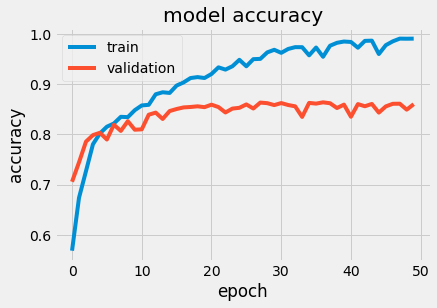

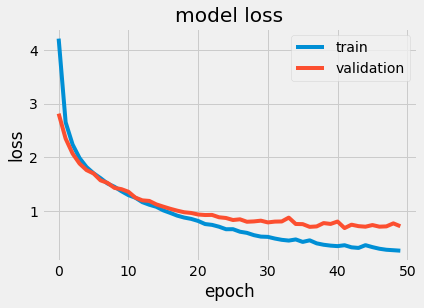

In [54]:
#  "Accuracy"
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

Model with change in dropout

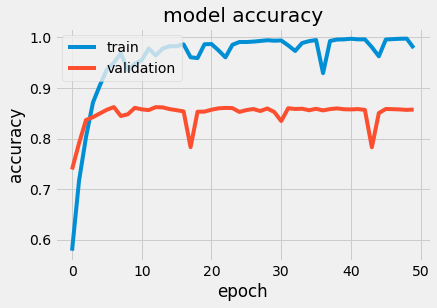

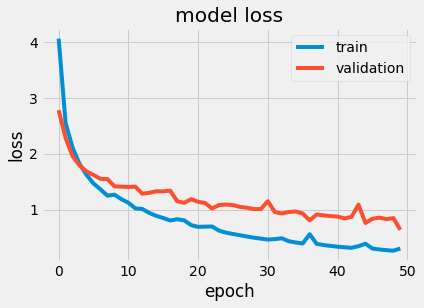

In [55]:
#  "Accuracy"
plt.plot(model_fit_drop.history['accuracy'])
plt.plot(model_fit_drop.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(model_fit_drop.history['loss'])
plt.plot(model_fit_drop.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

When you increase dropout beyond a certain threshold, it results in the model not being able to fit properly. Intuitively, a higher dropout rate would result in a higher variance to some of the layers, which also degrades training. Dropout is like all other forms of regularization in that it reduces model capacity. If you reduce the capacity too much, it is sure that you will get bad results.

Model with change in batch size

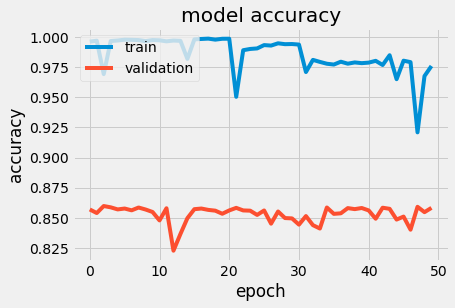

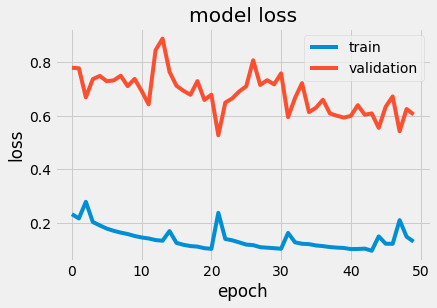

In [56]:
#  "Accuracy"
plt.plot(model_fit_batch.history['accuracy'])
plt.plot(model_fit_batch.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(model_fit_batch.history['loss'])
plt.plot(model_fit_batch.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

Model with decrease batch size clearly increased the accuracy. It can be seen that model has converged faster due to low batch size and kept on giving constant accuracy of 85%.

# Conclusion

Text classification of the Movie review dataset using Tensorflow hub and keras is performed. The class distribution is plotted, data pre processed and model built with L2 regularization. Post Training and evaluation of accuracies of the training and validation set, confusion matrix and the classficiation report is generated.
Hyperparameter tuning is performed by building two separate models one with Dropout and the other with batchsize update in model training and the differences in results comapred. 